In [ ]:
#mount drive to save models
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

Epoch [1/50], Train Loss: 1.3737503290176392, Test Loss: 0.6829624176025391
Epoch [2/50], Train Loss: 0.6861322522163391, Test Loss: 0.3868730664253235
Epoch [3/50], Train Loss: 0.39606305956840515, Test Loss: 0.2574503719806671
Epoch [4/50], Train Loss: 0.26994216442108154, Test Loss: 0.21245832741260529
Epoch [5/50], Train Loss: 0.2253328263759613, Test Loss: 0.19024425745010376
Epoch [6/50], Train Loss: 0.2002669870853424, Test Loss: 0.17333093285560608
Epoch [7/50], Train Loss: 0.18237094581127167, Test Loss: 0.1682862490415573
Epoch [8/50], Train Loss: 0.1757907122373581, Test Loss: 0.16746364533901215
Epoch [9/50], Train Loss: 0.17265745997428894, Test Loss: 0.1614558845758438
Epoch [10/50], Train Loss: 0.16599531471729279, Test Loss: 0.15146976709365845
Epoch [11/50], Train Loss: 0.15457391738891602, Test Loss: 0.15154048800468445
Epoch [12/50], Train Loss: 0.1544390469789505, Test Loss: 0.14781351387500763
Epoch [13/50], Train Loss: 0.15115979313850403, Test Loss: 0.14785151183

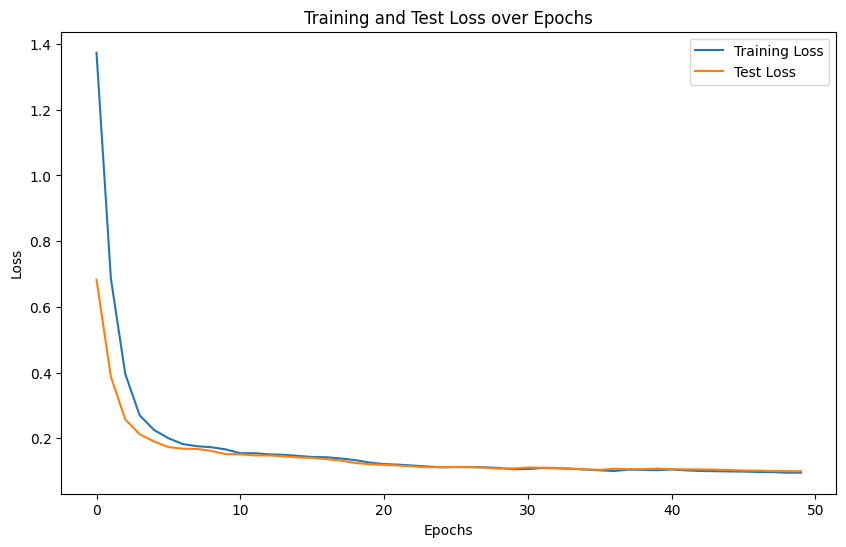

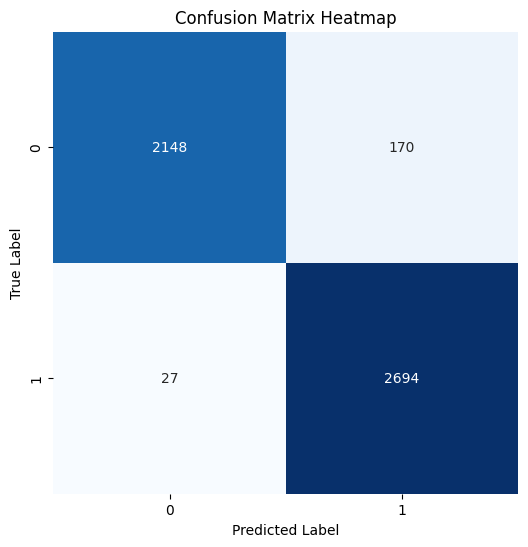

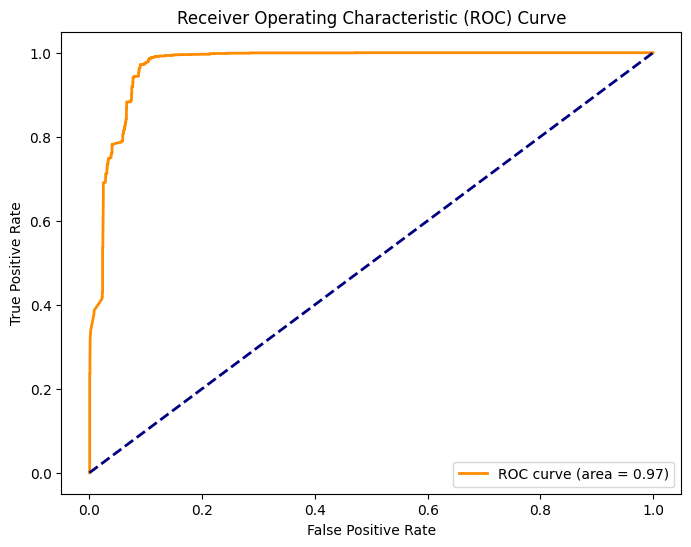


Performance Metrics:
Specificity: 0.93
FAR: 0.07
Precision: 0.94
Recall: 0.99
F1 Score: 0.96
Accuracy: 0.96


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.spike = nn.Hardtanh(0, 1)
        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()


        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size = 64
output_size = 2
num_epochs = 50
learning_rate = 0.01

snn_model = SNN(input_size, hidden_size, output_size)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate)
t = time.time() - s
print("training time:",t)
# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate specificity and FAR from confusion matrix
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)

# Calculate additional performance metrics
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.2f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))



In [ ]:
torch.save(snn_model.state_dict(), "/content/drive/My Drive/Final year project/models/snn.keras")

Epoch [1/50], Train Loss: 0.6746938824653625, Test Loss: 0.37888288497924805
Epoch [2/50], Train Loss: 0.4047728478908539, Test Loss: 0.2659054100513458
Epoch [3/50], Train Loss: 0.29378771781921387, Test Loss: 0.20833688974380493
Epoch [4/50], Train Loss: 0.23673327267169952, Test Loss: 0.1859990358352661
Epoch [5/50], Train Loss: 0.21276521682739258, Test Loss: 0.17350725829601288
Epoch [6/50], Train Loss: 0.19924396276474, Test Loss: 0.16115137934684753
Epoch [7/50], Train Loss: 0.18589161336421967, Test Loss: 0.150363951921463
Epoch [8/50], Train Loss: 0.1692599207162857, Test Loss: 0.14620837569236755
Epoch [9/50], Train Loss: 0.1666133999824524, Test Loss: 0.14080624282360077
Epoch [10/50], Train Loss: 0.1621217578649521, Test Loss: 0.13787929713726044
Epoch [11/50], Train Loss: 0.1569063514471054, Test Loss: 0.13565264642238617
Epoch [12/50], Train Loss: 0.14824151992797852, Test Loss: 0.1318155974149704
Epoch [13/50], Train Loss: 0.14540617167949677, Test Loss: 0.12484228610992

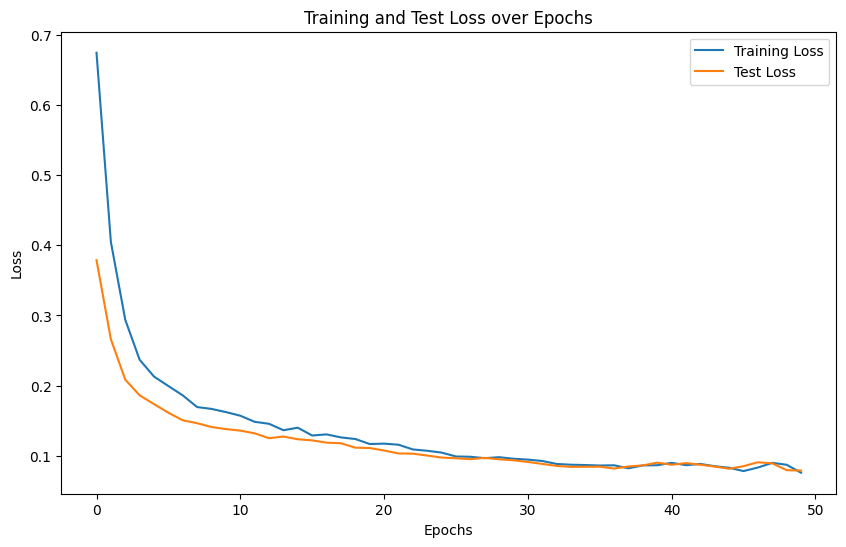

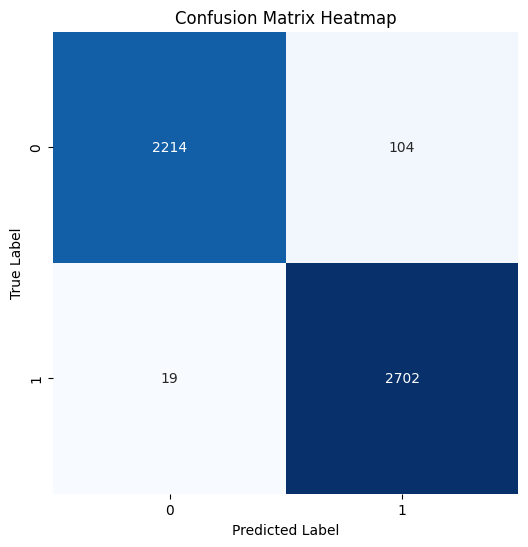

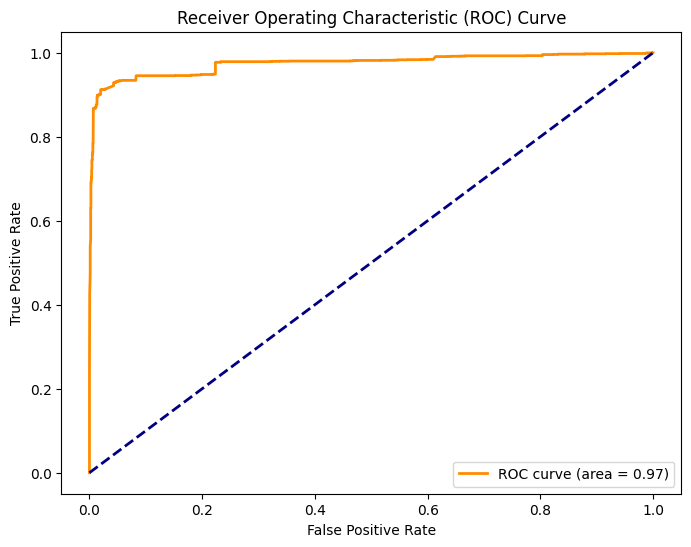


Performance Metrics:
Specificity: 0.96
FAR: 0.04
Precision: 0.96
Recall: 0.99
F1 Score: 0.98
Accuracy: 0.98


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F  # Added this line
import torch.optim as optim

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model with added hidden layer and dropout
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.Hardtanh(0, 1)
        self.hidden_layer = nn.Linear(hidden_size1, hidden_size2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = F.relu(self.hidden_layer(x))
        x = self.dropout(x)
        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = 2
dropout_rate = 0.2
num_epochs = 50
learning_rate = 0.01

snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate)
t = time.time() - s
print("training time:", t)

# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate specificity and FAR from confusion matrix
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)

# Calculate additional performance metrics
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.2f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))

Epoch [1/100], Train Loss: 0.7388495206832886, Test Loss: 0.629256546497345
Epoch [2/100], Train Loss: 0.6370807886123657, Test Loss: 0.5586812496185303
Epoch [3/100], Train Loss: 0.5706912279129028, Test Loss: 0.5033658146858215
Epoch [4/100], Train Loss: 0.5167068839073181, Test Loss: 0.45345452427864075
Epoch [5/100], Train Loss: 0.46719610691070557, Test Loss: 0.4071136713027954
Epoch [6/100], Train Loss: 0.42490723729133606, Test Loss: 0.36530250310897827
Epoch [7/100], Train Loss: 0.386139839887619, Test Loss: 0.3283720314502716
Epoch [8/100], Train Loss: 0.3498043715953827, Test Loss: 0.29722151160240173
Epoch [9/100], Train Loss: 0.31906458735466003, Test Loss: 0.27241775393486023
Epoch [10/100], Train Loss: 0.29463428258895874, Test Loss: 0.2516746520996094
Epoch [11/100], Train Loss: 0.27583369612693787, Test Loss: 0.23450174927711487
Epoch [12/100], Train Loss: 0.25730887055397034, Test Loss: 0.22039590775966644
Epoch [13/100], Train Loss: 0.24367544054985046, Test Loss: 0.2

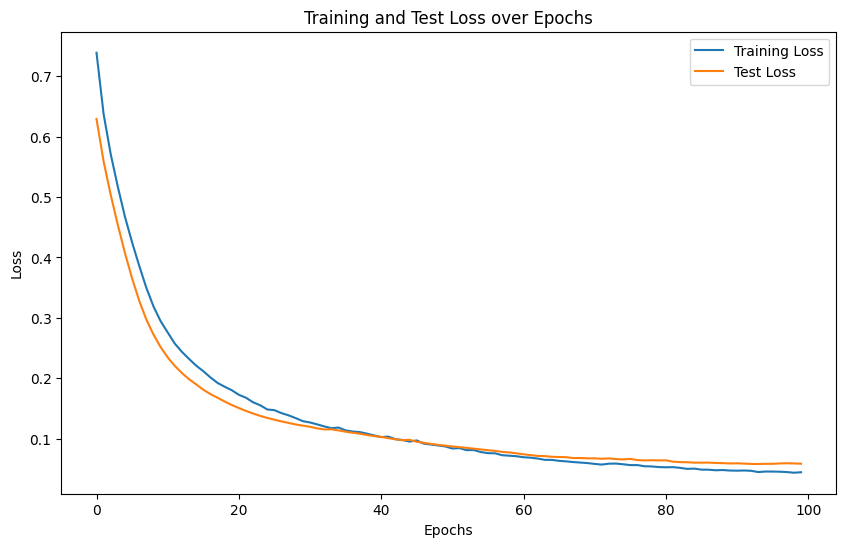

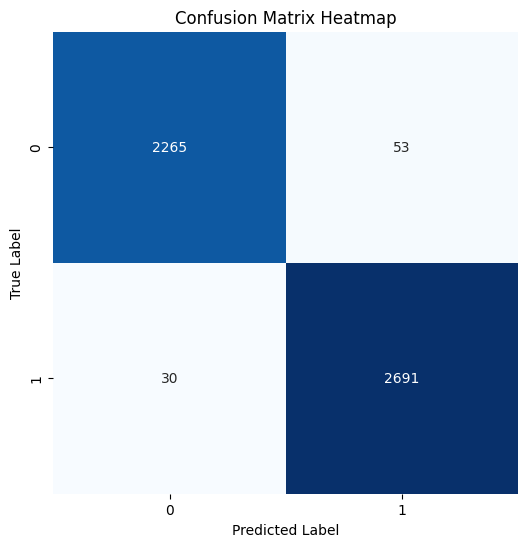

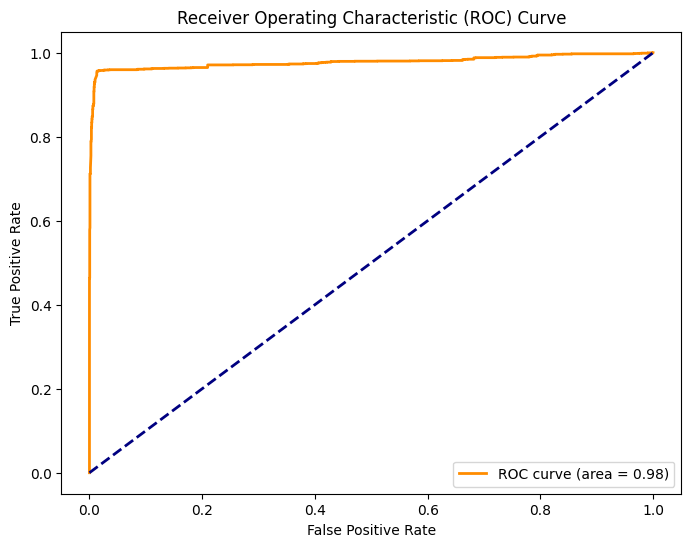


Performance Metrics:
Specificity: 0.9771
FAR: 0.02
Precision: 0.9807
Recall: 0.9890
F1 Score: 0.9848
Accuracy: 0.9835


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model with added hidden layer and dropout
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.Hardtanh(0, 1)
        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = F.relu(self.hidden_layer1(x))
        x = F.relu(self.hidden_layer2(x))
        x = self.dropout(x)
        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add L2 regularization

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
learning_rate = 0.001
patience = 10

snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience)
t = time.time() - s
print("training time:", t)

# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate specificity and FAR from confusion matrix
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)

# Calculate additional performance metrics
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.4f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Accuracy: {:.4f}".format(accuracy))

In [ ]:
# Add a new dimension to the train_data tensor
train_data_3d = train_data.unsqueeze(1)

# Apply data augmentation
train_data_augmented = train_data_3d.permute(0, 2, 1)  # Adjust the shape for data augmentation
for i in range(len(train_data_augmented)):
    train_data_augmented[i] = data_transforms(train_data_augmented[i])

# Reshape the data back to the original shape
train_data_augmented = train_data_augmented.permute(0, 2, 1)


Trying activation function: relu
Epoch [1/50], Train Loss: 0.7892863154411316, Test Loss: 0.4838113784790039
Epoch [2/50], Train Loss: 0.4980512857437134, Test Loss: 0.3679423928260803
Epoch [3/50], Train Loss: 0.391912043094635, Test Loss: 0.2941988706588745
Epoch [4/50], Train Loss: 0.3228135108947754, Test Loss: 0.25156429409980774
Epoch [5/50], Train Loss: 0.281269371509552, Test Loss: 0.22991503775119781
Epoch [6/50], Train Loss: 0.259795606136322, Test Loss: 0.2135896235704422
Epoch [7/50], Train Loss: 0.2459888607263565, Test Loss: 0.20479951798915863
Epoch [8/50], Train Loss: 0.23273728787899017, Test Loss: 0.19476158916950226
Epoch [9/50], Train Loss: 0.22276556491851807, Test Loss: 0.18470576405525208
Epoch [10/50], Train Loss: 0.21247614920139313, Test Loss: 0.17075827717781067
Epoch [11/50], Train Loss: 0.19630204141139984, Test Loss: 0.1545839160680771
Epoch [12/50], Train Loss: 0.17563432455062866, Test Loss: 0.15011382102966309
Epoch [13/50], Train Loss: 0.1713058948516

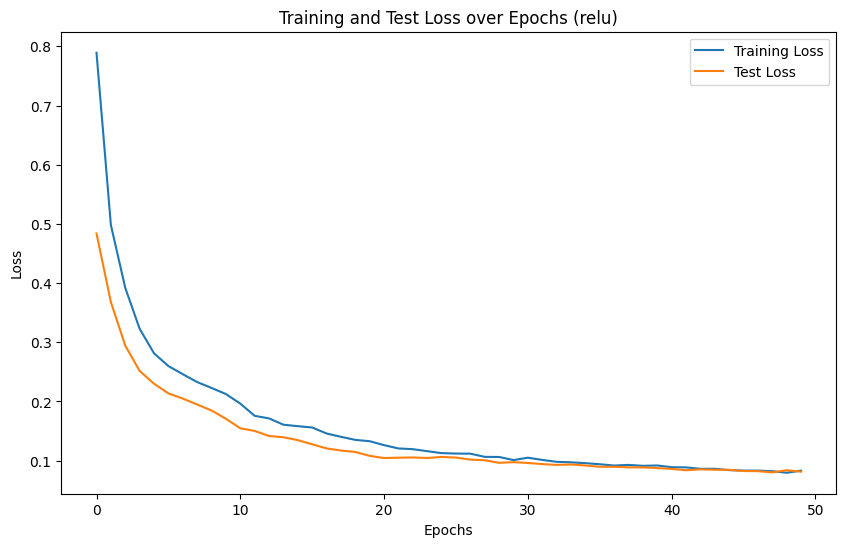


Performance Metrics:
Specificity: 0.95
FAR: 0.05
Precision: 0.96
Recall: 0.98
F1 Score: 0.97
Accuracy: 0.97

Trying activation function: leaky_relu
Epoch [1/50], Train Loss: 0.6556650400161743, Test Loss: 0.3794064223766327
Epoch [2/50], Train Loss: 0.3987490236759186, Test Loss: 0.28539904952049255
Epoch [3/50], Train Loss: 0.31346410512924194, Test Loss: 0.24087852239608765
Epoch [4/50], Train Loss: 0.2701949179172516, Test Loss: 0.22067955136299133
Epoch [5/50], Train Loss: 0.2511938214302063, Test Loss: 0.19642624258995056
Epoch [6/50], Train Loss: 0.2237372100353241, Test Loss: 0.17720915377140045
Epoch [7/50], Train Loss: 0.20289196074008942, Test Loss: 0.15755680203437805
Epoch [8/50], Train Loss: 0.1844203621149063, Test Loss: 0.14568817615509033
Epoch [9/50], Train Loss: 0.1695905327796936, Test Loss: 0.14507047832012177
Epoch [10/50], Train Loss: 0.16619251668453217, Test Loss: 0.15342293679714203
Epoch [11/50], Train Loss: 0.17293809354305267, Test Loss: 0.14761626720428467

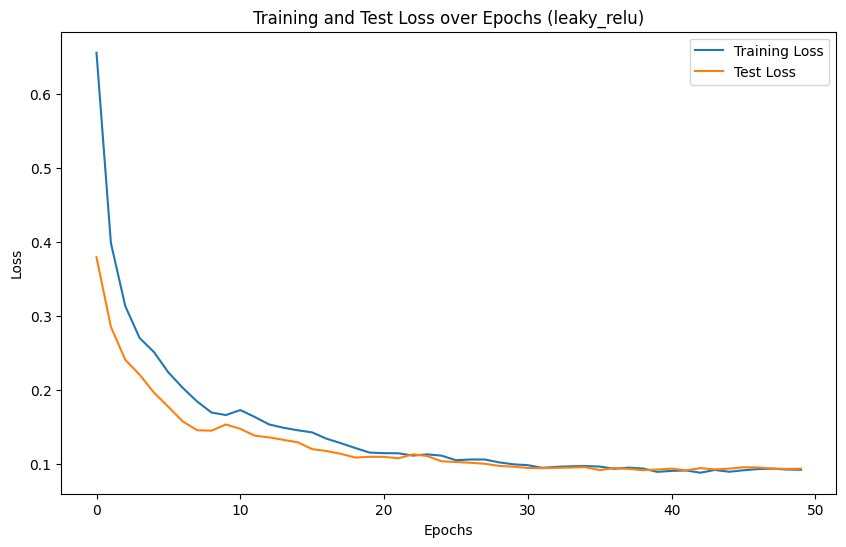


Performance Metrics:
Specificity: 0.94
FAR: 0.06
Precision: 0.95
Recall: 0.99
F1 Score: 0.97
Accuracy: 0.97

Trying activation function: tanh
Epoch [1/50], Train Loss: 0.6136801838874817, Test Loss: 0.2878279983997345
Epoch [2/50], Train Loss: 0.31139400601387024, Test Loss: 0.2632964849472046
Epoch [3/50], Train Loss: 0.2888059616088867, Test Loss: 0.24754737317562103
Epoch [4/50], Train Loss: 0.27024999260902405, Test Loss: 0.21604211628437042
Epoch [5/50], Train Loss: 0.23799121379852295, Test Loss: 0.19607137143611908
Epoch [6/50], Train Loss: 0.21692685782909393, Test Loss: 0.17478591203689575
Epoch [7/50], Train Loss: 0.19344636797904968, Test Loss: 0.15968011319637299
Epoch [8/50], Train Loss: 0.17590662837028503, Test Loss: 0.15537552535533905
Epoch [9/50], Train Loss: 0.17107394337654114, Test Loss: 0.15554223954677582
Epoch [10/50], Train Loss: 0.16665951907634735, Test Loss: 0.14813955128192902
Epoch [11/50], Train Loss: 0.15887250006198883, Test Loss: 0.14317108690738678
E

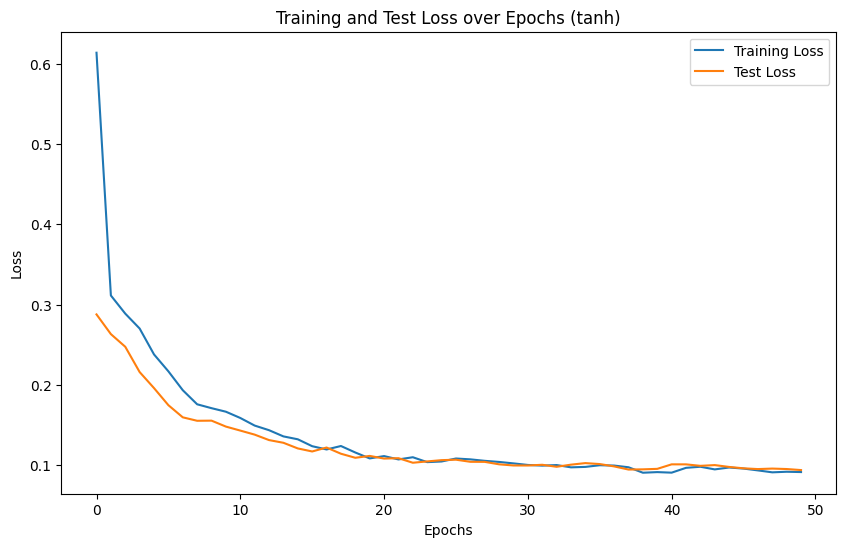


Performance Metrics:
Specificity: 0.96
FAR: 0.04
Precision: 0.96
Recall: 0.98
F1 Score: 0.97
Accuracy: 0.97

Trying activation function: sigmoid
Epoch [1/50], Train Loss: 1.186859130859375, Test Loss: 0.7356315851211548
Epoch [2/50], Train Loss: 0.772952675819397, Test Loss: 0.5700533986091614
Epoch [3/50], Train Loss: 0.6117371320724487, Test Loss: 0.5370356440544128
Epoch [4/50], Train Loss: 0.5772289037704468, Test Loss: 0.5026169419288635
Epoch [5/50], Train Loss: 0.5443876385688782, Test Loss: 0.44046273827552795
Epoch [6/50], Train Loss: 0.4808851480484009, Test Loss: 0.37122291326522827
Epoch [7/50], Train Loss: 0.41094300150871277, Test Loss: 0.3121670186519623
Epoch [8/50], Train Loss: 0.34787794947624207, Test Loss: 0.2737821638584137
Epoch [9/50], Train Loss: 0.30641210079193115, Test Loss: 0.2445109337568283
Epoch [10/50], Train Loss: 0.2768813967704773, Test Loss: 0.2275988757610321
Epoch [11/50], Train Loss: 0.25827136635780334, Test Loss: 0.21800914406776428
Epoch [12/5

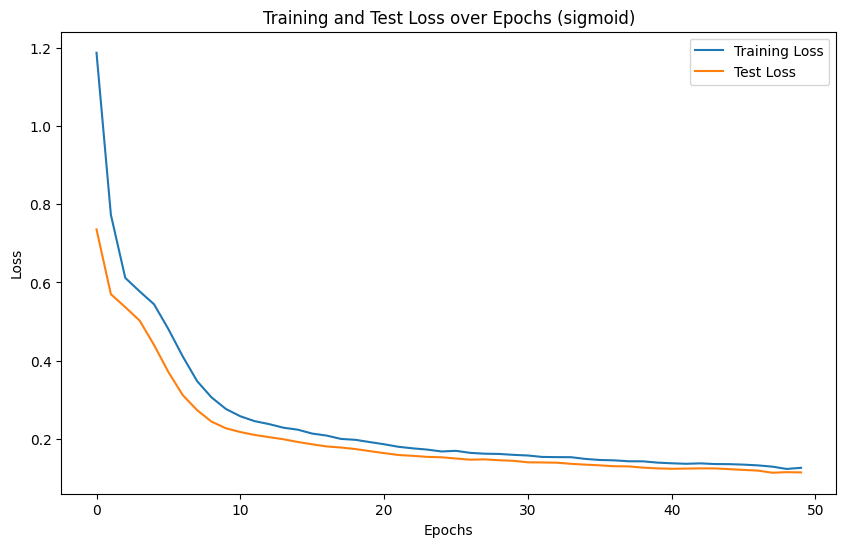


Performance Metrics:
Specificity: 0.93
FAR: 0.07
Precision: 0.95
Recall: 0.99
F1 Score: 0.97
Accuracy: 0.96

Trying activation function: silu
Epoch [1/50], Train Loss: 0.7475265264511108, Test Loss: 0.5096285343170166
Epoch [2/50], Train Loss: 0.5168167352676392, Test Loss: 0.354393869638443
Epoch [3/50], Train Loss: 0.36777544021606445, Test Loss: 0.28517651557922363
Epoch [4/50], Train Loss: 0.3024137020111084, Test Loss: 0.25277793407440186
Epoch [5/50], Train Loss: 0.2700340151786804, Test Loss: 0.22810128331184387
Epoch [6/50], Train Loss: 0.24264714121818542, Test Loss: 0.20739877223968506
Epoch [7/50], Train Loss: 0.2228134274482727, Test Loss: 0.18996363878250122
Epoch [8/50], Train Loss: 0.2042175978422165, Test Loss: 0.17489755153656006
Epoch [9/50], Train Loss: 0.1857246458530426, Test Loss: 0.16497734189033508
Epoch [10/50], Train Loss: 0.17543011903762817, Test Loss: 0.15104106068611145
Epoch [11/50], Train Loss: 0.1613132506608963, Test Loss: 0.14131814241409302
Epoch [1

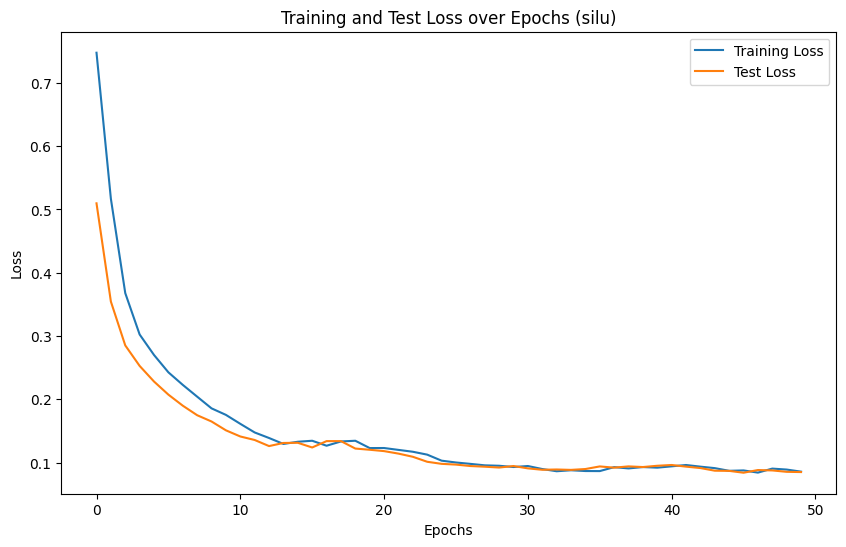


Performance Metrics:
Specificity: 0.95
FAR: 0.05
Precision: 0.96
Recall: 0.99
F1 Score: 0.97
Accuracy: 0.97

Trying activation function: selu
Epoch [1/50], Train Loss: 1.1961922645568848, Test Loss: 0.9776338338851929
Epoch [2/50], Train Loss: 1.0087484121322632, Test Loss: 0.3173885643482208
Epoch [3/50], Train Loss: 0.3477270007133484, Test Loss: 0.346466064453125
Epoch [4/50], Train Loss: 0.37411874532699585, Test Loss: 0.3728514611721039
Epoch [5/50], Train Loss: 0.3966214656829834, Test Loss: 0.29298654198646545
Epoch [6/50], Train Loss: 0.32022008299827576, Test Loss: 0.2371472269296646
Epoch [7/50], Train Loss: 0.25742778182029724, Test Loss: 0.23652596771717072
Epoch [8/50], Train Loss: 0.25104957818984985, Test Loss: 0.2472725510597229
Epoch [9/50], Train Loss: 0.260739266872406, Test Loss: 0.24648362398147583
Epoch [10/50], Train Loss: 0.2605021893978119, Test Loss: 0.23059949278831482
Epoch [11/50], Train Loss: 0.243832066655159, Test Loss: 0.21019919216632843
Epoch [12/50]

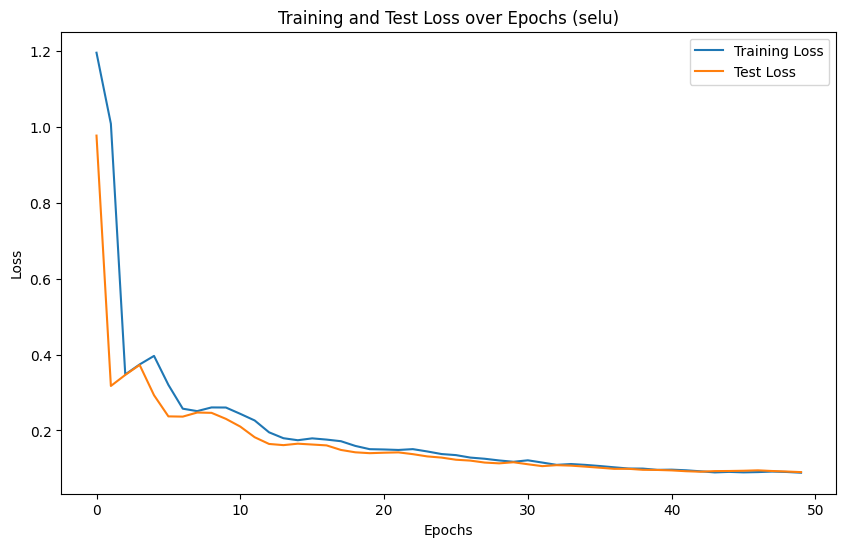


Performance Metrics:
Specificity: 0.94
FAR: 0.06
Precision: 0.95
Recall: 0.99
F1 Score: 0.97
Accuracy: 0.97

Trying activation function: gelu
Epoch [1/50], Train Loss: 0.6730915307998657, Test Loss: 0.47865840792655945
Epoch [2/50], Train Loss: 0.4889484643936157, Test Loss: 0.35300031304359436
Epoch [3/50], Train Loss: 0.36728447675704956, Test Loss: 0.2724594473838806
Epoch [4/50], Train Loss: 0.290486603975296, Test Loss: 0.22525963187217712
Epoch [5/50], Train Loss: 0.24378114938735962, Test Loss: 0.19881831109523773
Epoch [6/50], Train Loss: 0.21681255102157593, Test Loss: 0.1863199919462204
Epoch [7/50], Train Loss: 0.2036520540714264, Test Loss: 0.17559398710727692
Epoch [8/50], Train Loss: 0.19295723736286163, Test Loss: 0.16743475198745728
Epoch [9/50], Train Loss: 0.18598498404026031, Test Loss: 0.15535002946853638
Epoch [10/50], Train Loss: 0.17285765707492828, Test Loss: 0.1478906273841858
Epoch [11/50], Train Loss: 0.16378732025623322, Test Loss: 0.14435353875160217
Epoch

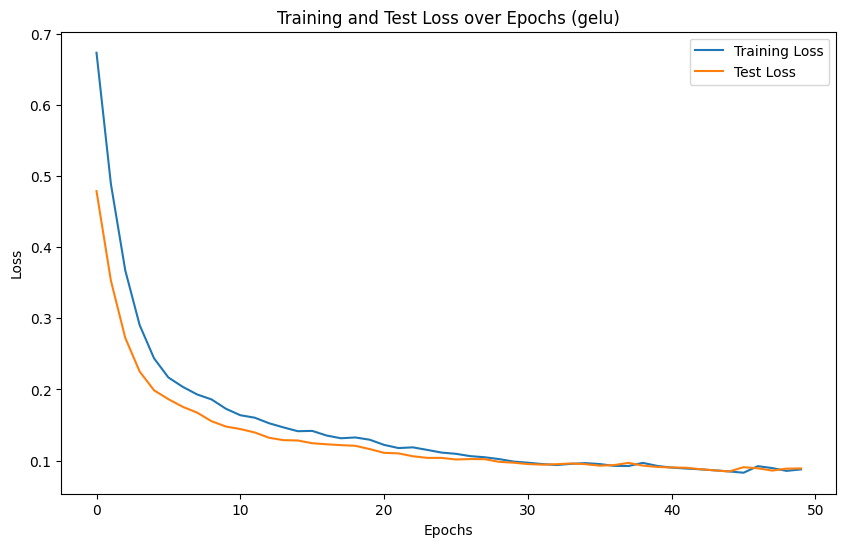


Performance Metrics:
Specificity: 0.95
FAR: 0.05
Precision: 0.96
Recall: 0.99
F1 Score: 0.97
Accuracy: 0.97


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model with added hidden layer and dropout
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation_fn, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.Hardtanh(0, 1)
        self.hidden_layer = nn.Linear(hidden_size1, hidden_size2)
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(p=dropout_rate)
        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.activation_fn(self.hidden_layer(x))
        x = self.dropout(x)
        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = 2
dropout_rate = 0.2
num_epochs = 50
learning_rate = 0.01

# Experiment with different activation functions
activation_functions = [F.relu, F.leaky_relu, F.tanh, F.sigmoid, F.silu, F.selu, F.gelu]
for activation_fn in activation_functions:
    print(f"\nTrying activation function: {activation_fn.__name__}")
    snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, activation_fn, dropout_rate)
    import time
    s = time.time()
    history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate)
    t = time.time() - s
    print(f"Training time: {t:.2f} seconds")

    # Plot the training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title(f'Training and Test Loss over Epochs ({activation_fn.__name__})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # SNN on the test set
    with torch.no_grad():
        test_outputs = snn_model(test_data)
        _, predicted = torch.max(test_outputs, 1)

    # Calculate confusion matrix
    conf_mat = confusion_matrix(test_labels, predicted)

    # Calculate performance metrics
    TN = conf_mat[0, 0]
    FP = conf_mat[0, 1]
    FN = conf_mat[1, 0]
    TP = conf_mat[1, 1]

    specificity = TN / (TN + FP)
    far = FP / (FP + TN)
    precision = precision_score(test_labels, predicted)
    recall = recall_score(test_labels, predicted)
    f1 = f1_score(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)

    # Print performance metrics
    print("\nPerformance Metrics:")
    print("Specificity: {:.2f}".format(specificity))
    print("FAR: {:.2f}".format(far))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))
    print("Accuracy: {:.2f}".format(accuracy))

Epoch [1/50], Train Loss: 0.5707104206085205, Test Loss: 0.4935661554336548
Epoch [2/50], Train Loss: 0.2642694413661957, Test Loss: 0.4146971106529236
Epoch [3/50], Train Loss: 0.20841187238693237, Test Loss: 0.3677123486995697
Epoch [4/50], Train Loss: 0.18935269117355347, Test Loss: 0.3307024836540222
Epoch [5/50], Train Loss: 0.17057479918003082, Test Loss: 0.28497645258903503
Epoch [6/50], Train Loss: 0.15375618636608124, Test Loss: 0.24674835801124573
Epoch [7/50], Train Loss: 0.14910069108009338, Test Loss: 0.20854085683822632
Epoch [8/50], Train Loss: 0.13553526997566223, Test Loss: 0.18353435397148132
Epoch [9/50], Train Loss: 0.1264624148607254, Test Loss: 0.17158716917037964
Epoch [10/50], Train Loss: 0.12467899173498154, Test Loss: 0.16009779274463654
Epoch [11/50], Train Loss: 0.11882773786783218, Test Loss: 0.1486082822084427
Epoch [12/50], Train Loss: 0.11866974085569382, Test Loss: 0.13364513218402863
Epoch [13/50], Train Loss: 0.10793999582529068, Test Loss: 0.12793391

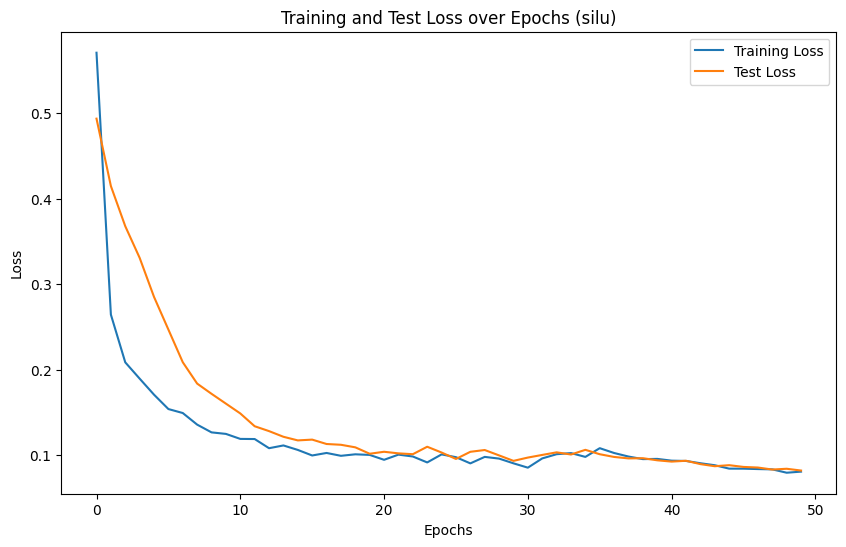


Performance Metrics:
Specificity: 0.95
FAR: 0.05
Precision: 0.96
Recall: 0.98
F1 Score: 0.97
Accuracy: 0.97


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model with additional layers
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation_fn, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.Hardtanh(0, 1)
        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.activation_fn = activation_fn
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size2)  # Added batch normalization

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size2 // 2)  # Added another hidden layer
        self.activation_fn2 = F.selu  # Using a different activation function for the second hidden layer
        self.dropout2 = nn.Dropout(p=dropout_rate // 2)  # Lower dropout rate for the second hidden layer
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2 // 2)  # Added batch normalization

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2 // 2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.activation_fn(self.hidden_layer1(x))
        x = self.dropout1(x)
        x = self.batch_norm1(x)

        x = self.activation_fn2(self.hidden_layer2(x))
        x = self.dropout2(x)
        x = self.batch_norm2(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss
# ... (same as before)

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = 2
activation_fn = F.silu  # Using SiLU activation function
dropout_rate = 0.2
num_epochs = 50
learning_rate = 0.01

snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, activation_fn, dropout_rate)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate)
t = time.time() - s
print(f"Training time: {t:.2f} seconds")

# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title(f'Training and Test Loss over Epochs ({activation_fn.__name__})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Calculate performance metrics
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.2f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))

Epoch [1/50], Train Loss: 0.7184799909591675, Test Loss: 0.5710388422012329
Epoch [2/50], Train Loss: 0.5767134428024292, Test Loss: 0.3978968858718872
Epoch [3/50], Train Loss: 0.40530410408973694, Test Loss: 0.2596609890460968
Epoch [4/50], Train Loss: 0.27487850189208984, Test Loss: 0.2241399884223938
Epoch [5/50], Train Loss: 0.23791740834712982, Test Loss: 0.19576555490493774
Epoch [6/50], Train Loss: 0.20568375289440155, Test Loss: 0.18061812222003937
Epoch [7/50], Train Loss: 0.18684758245944977, Test Loss: 0.16420575976371765
Epoch [8/50], Train Loss: 0.16860352456569672, Test Loss: 0.15599915385246277
Epoch [9/50], Train Loss: 0.16123929619789124, Test Loss: 0.15271064639091492
Epoch [10/50], Train Loss: 0.15082105994224548, Test Loss: 0.13282829523086548
Epoch [11/50], Train Loss: 0.1343689113855362, Test Loss: 0.1357494741678238
Epoch [12/50], Train Loss: 0.13708500564098358, Test Loss: 0.12721490859985352
Epoch [13/50], Train Loss: 0.12589441239833832, Test Loss: 0.11915303

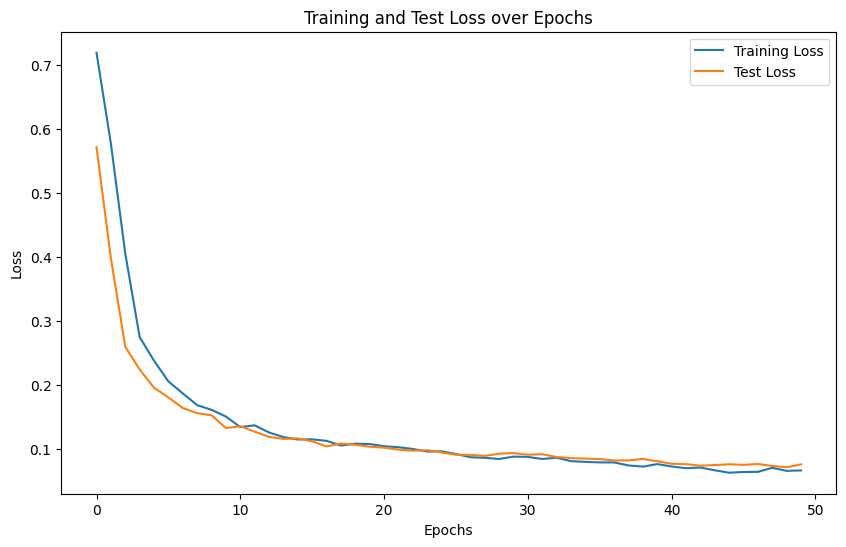

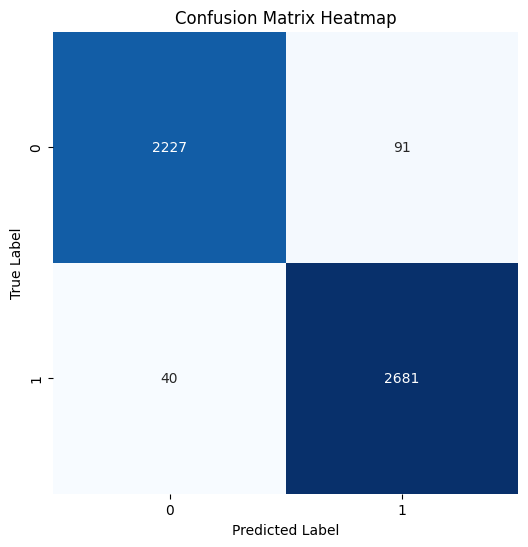

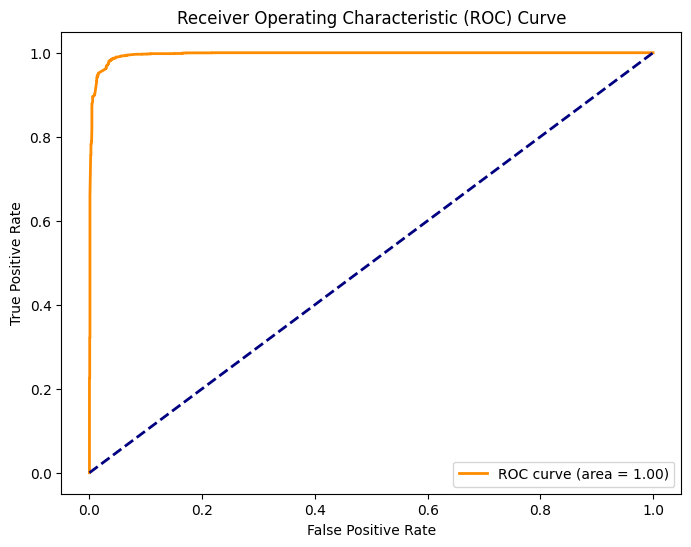


Performance Metrics:
Specificity: 0.96
FAR: 0.04
Precision: 0.97
Recall: 0.99
F1 Score: 0.98
Accuracy: 0.97


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(SelfAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.head_dim = hidden_size // num_heads

        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        batch_size = x.size(0)

        query = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        key = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        value = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention_weights = F.softmax(scores, dim=-1)
        x = torch.matmul(attention_weights, value).permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hidden_size)
        x = self.fc_out(x)

        return x

# Define SNN model with self-attention layer
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, num_heads, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.Hardtanh(0, 1)
        self.hidden_layer = nn.Linear(hidden_size1, hidden_size2)
        self.self_attention = SelfAttention(hidden_size2, num_heads)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = F.relu(self.hidden_layer(x))
        x = self.self_attention(x)  # Apply self-attention
        x = self.dropout(x)
        x = torch.mm(x.view(x.size(0), -1), self.synaptic_weights)  # Flatten the tensor
        return x

# Training loop with test loss
# ... (rest of the code remains the same)
# Training loop with test loss
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = 2
num_heads = 4  # Number of attention heads
dropout_rate = 0.2
num_epochs = 50
learning_rate = 0.01

snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, num_heads, dropout_rate)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate)
t = time.time() - s
print("training time:", t)

# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate specificity and FAR from confusion matrix
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)

# Calculate additional performance metrics
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.2f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))

In [ ]:
with torch.no_grad():
    test_data = torch.tensor(X_test.values, dtype=torch.float32)
    test_labels = torch.tensor(y_test.values, dtype=torch.long)

    test_outputs = snn_model_2(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate accuracy
correct = (predicted == test_labels).sum().item()
total = test_labels.size(0)
accuracy = correct / total * 100
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 98.97%


Epoch [1/50], Train Loss: 1.6258201599121094, Test Loss: 0.9966450929641724
Epoch [2/50], Train Loss: 0.9796369075775146, Test Loss: 0.6694568991661072
Epoch [3/50], Train Loss: 0.6717983484268188, Test Loss: 0.46445906162261963
Epoch [4/50], Train Loss: 0.4732913374900818, Test Loss: 0.3408050239086151
Epoch [5/50], Train Loss: 0.351484090089798, Test Loss: 0.2869156301021576
Epoch [6/50], Train Loss: 0.29717278480529785, Test Loss: 0.25563445687294006
Epoch [7/50], Train Loss: 0.2644323706626892, Test Loss: 0.2314458191394806
Epoch [8/50], Train Loss: 0.23969131708145142, Test Loss: 0.2087089866399765
Epoch [9/50], Train Loss: 0.21632805466651917, Test Loss: 0.19522669911384583
Epoch [10/50], Train Loss: 0.20188657939434052, Test Loss: 0.18848343193531036
Epoch [11/50], Train Loss: 0.19390320777893066, Test Loss: 0.18262383341789246
Epoch [12/50], Train Loss: 0.1882125735282898, Test Loss: 0.1758660525083542
Epoch [13/50], Train Loss: 0.18052184581756592, Test Loss: 0.169641450047492

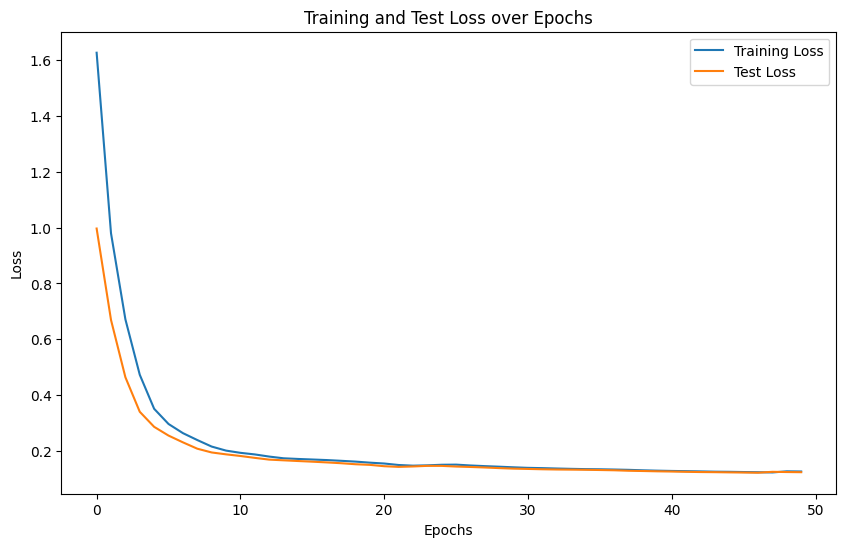

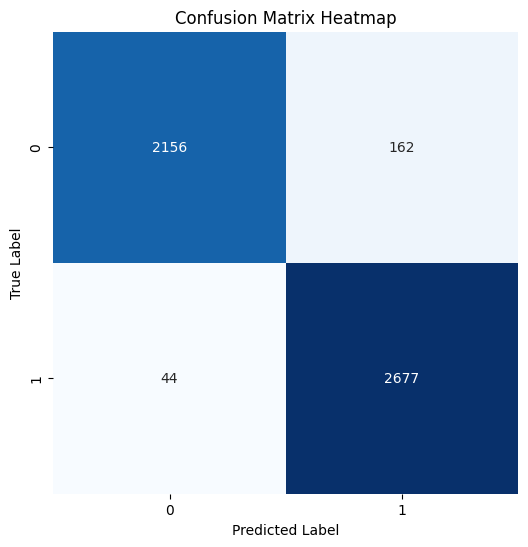

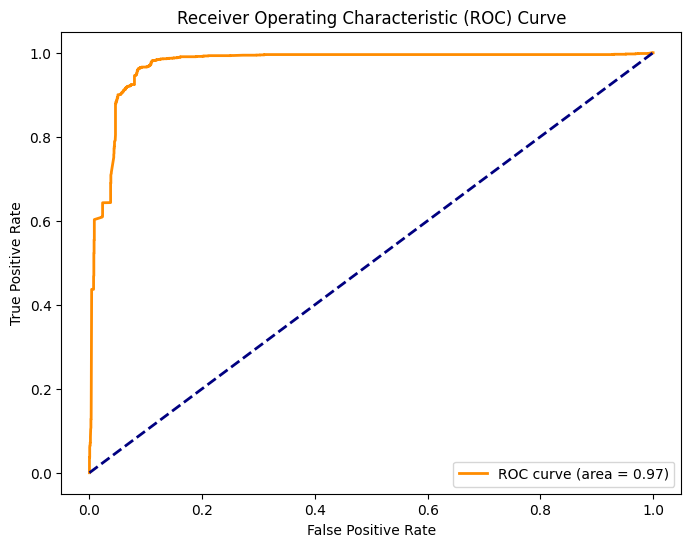


Performance Metrics:
Specificity: 0.93
FAR: 0.07
Precision: 0.94
Recall: 0.98
F1 Score: 0.96
Accuracy: 0.96


In [ ]:
# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.spike = nn.Hardtanh(0, 1)
        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()


        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size = 64
output_size = 2
num_epochs = 50
learning_rate = 0.01

snn_model = SNN(input_size, hidden_size, output_size)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate)
t = time.time() - s
print("training time:",t)
# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate specificity and FAR from confusion matrix
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)

# Calculate additional performance metrics
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.2f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))
